In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse
import jupyterlab
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler

In [2]:
cov_blue = np.vstack(([1/8,0],[0,1/4]))
mean_blue = np.array(([0,0]))
cov_red = np.vstack(([2,0],[0,1/2]))
mean_red = np.array(([1,2]))

In [3]:
N = 500
P = 100

In [4]:
gaussian_blue = np.random.multivariate_normal(mean=mean_blue, cov=cov_blue, size=N)
gaussian_red = np.random.multivariate_normal(mean=mean_red, cov=cov_red, size=N)

/tmp/ipykernel_435/3133126334.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_435/3133126334.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_435/3133126334.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(gaussian_blue[:,0], gaussian_blue[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_435/3133126334.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt str

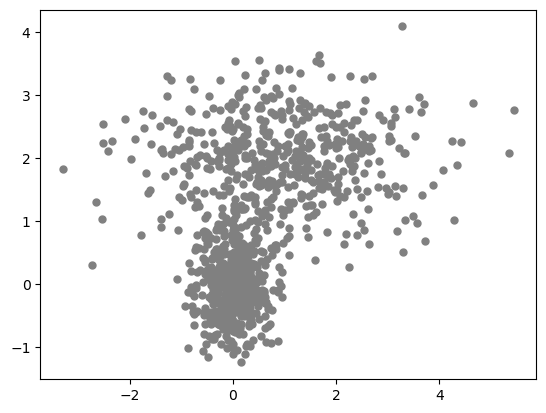

In [5]:
plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
plt.plot(gaussian_blue[:,0], gaussian_blue[:,1], 'bo', color='grey', marker='.', markersize=10)

### Initializing in a 'separable' way

In [6]:
estimated_mean_0 = np.array((-2,-1))
estimated_cov_0 = np.eye(2)
estimated_mean_1 = np.array((4,4))
estimated_cov_1 = np.eye(2)

In [7]:
weighted_data = np.ones((2*N,5))

In [8]:
for i in range(N):
    weighted_data[i,0] = gaussian_blue[i,0]
    weighted_data[i,1] = gaussian_blue[i,1]
    weighted_data[N+i,0] = gaussian_red[i,0]
    weighted_data[N+i,1] = gaussian_red[i,1]

In [9]:
def unsupervised_gmm(initial_means, initial_cov, data, iterations):
    """a function to make unsupervised classification, by a GMM approach

    Parameters
    ----------------------------------
    initial means : dict
    a dictionary in which the initial means are the values

    initial cov : dict
    a dictionary in which the initial covariances are the values

    data : array-like object
    the data we want to analyze

    iterations : int
    the number of iterations wanted
    -------------------------------
    """
    n=0
    pi_gmm_0 = 1/2
    pi_gmm_1 = 1/2
    mu_hat_gmm_0 = initial_means['0']
    sigma_hat_gmm_0 = initial_cov['0']
    mu_hat_gmm_1 = initial_means['1']
    sigma_hat_gmm_1 = initial_cov['1']
    dim = data.shape[0]
    while n<=iterations:
        #first, compute the new weights
        for i in range(dim):
            weight_0 = multivariate_normal.pdf(x=data[i,0:2],
                                               mean=mu_hat_gmm_0,cov=sigma_hat_gmm_0)            
            weight_1 = multivariate_normal.pdf(x=data[i,0:2],
                                               mean=mu_hat_gmm_1,cov=sigma_hat_gmm_1)
            denom = (pi_gmm_0*weight_0)+(pi_gmm_1*weight_1)
            weighted_data[i,2] = (pi_gmm_0*weight_0)/denom
            weighted_data[i,3] = (pi_gmm_1*weight_1)/denom
        #update of the parameters
        #dictionnary would probably be more efficient
        pi_gmm_0 = np.mean(data[:,2])
        pi_gmm_1 = np.mean(data[:,3])
        sum_weights_0 = np.sum(data[:,2])
        sum_weights_1 = np.sum(data[:,3])
        mu_hat_gmm_0 = np.sum(data[:,0:2]*data[:,2].reshape((dim,1)),axis=0)/sum_weights_0
        mu_hat_gmm_1 = np.sum(data[:,0:2]*data[:,3].reshape((dim,1)),axis=0)/sum_weights_1
        sigma_hat_gmm_0 = np.zeros((2,2))
        sigma_hat_gmm_1 = np.zeros((2,2))
        for i in range(dim):
            sigma_hat_gmm_0 = sigma_hat_gmm_0 + np.matmul((data[i,0:2]-mu_hat_gmm_0).reshape((2,1)),(data[i,0:2]-mu_hat_gmm_0).reshape((1,2)))*data[i,2]
            sigma_hat_gmm_1 = sigma_hat_gmm_1 + np.matmul((data[i,0:2]-mu_hat_gmm_1).reshape((2,1)),(data[i,0:2]-mu_hat_gmm_1).reshape((1,2)))*data[i,3]
        sigma_hat_gmm_0 = sigma_hat_gmm_0/sum_weights_0
        sigma_hat_gmm_1 = sigma_hat_gmm_1/sum_weights_1
        n+=1
    for i in range(dim):
        if data[i,2]>data[i,3]:
            data[i,4] = 0
        else:
            data[i,4] = 1

    
    return data
 

In [10]:
test_means = {'0':estimated_mean_0,'1':estimated_mean_1}
test_cov = {'0':estimated_cov_0,'1':estimated_cov_1}

In [11]:
test_unsup = unsupervised_gmm(initial_means=test_means, initial_cov=test_cov,data=weighted_data,iterations=100)

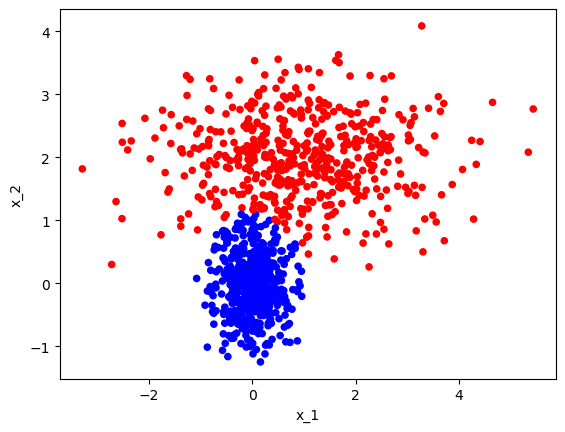

In [12]:
test_plot = pd.DataFrame(test_unsup)
test_plot.columns = ['x_1','x_2','w_0','w_1','label']
colors = {0:'blue', 1:'red'}
color_list = [colors[group] for group in test_plot['label']]
ax = test_plot.plot.scatter('x_1','x_2', c=color_list)

It works quite well

# K-means clustering (by hand)

We aim to find $R_1,...,R_M$ as : \
$\arg \min_{R_1,...,R_M} \sum_{m=1}^M \sum_{x \in R_m} \vert \vert x - \hat{\mu}_m \vert \vert _2^2$

In [13]:
group_0 = np.random.multivariate_normal(mean=mean_blue, cov=cov_blue, size=P)
group_1 = np.random.multivariate_normal(mean=mean_red, cov=cov_red, size=P)
group_2 = np.random.laplace(loc=4, scale=1/2, size=(P,2))
group_3 = np.random.uniform(low=-3, high=4, size = (int(P/2),2))

/tmp/ipykernel_435/1350591591.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(diff_groups[i][:,0], diff_groups[i][:,1], 'bo', marker='.', markersize=10, color=diff_colors[i])
/tmp/ipykernel_435/1350591591.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(diff_groups[i][:,0], diff_groups[i][:,1], 'bo', marker='.', markersize=10, color=diff_colors[i])


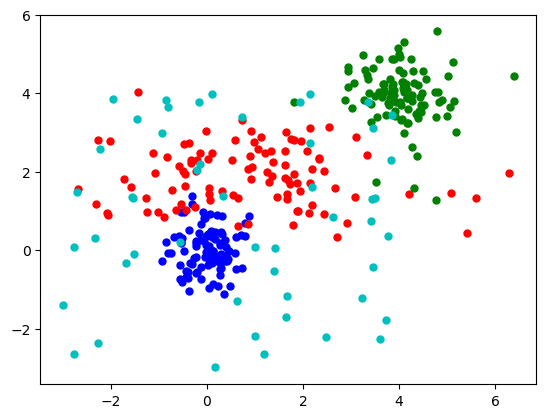

In [14]:
diff_groups = [group_0, group_1, group_2, group_3]
diff_colors = ['b','r','g','c','m']
for i in range(4):
    plt.plot(diff_groups[i][:,0], diff_groups[i][:,1], 'bo', marker='.', markersize=10, color=diff_colors[i])

In [15]:
diff_data = np.vstack((group_0,group_1,group_2,group_3))
diff_data_label = np.ones((diff_data.shape[0],1))
diff_data = np.hstack((diff_data, diff_data_label))

In [16]:
def euclidian_dist(x,y):
    z = ((x[0]-y[0])**2)+(x[1]-y[1])**2
    return z

In [17]:
k=3
iterations = 100

In [18]:
centroids = np.random.uniform(low=-2., high=6, size=(k,2))

In [19]:
distances = np.ones((diff_data.shape[0],k))
df_labeled = pd.DataFrame(diff_data)
df_labeled.columns = ['x_1','x_2','label']
n=0
while n<=iterations:
    n+=1
    for cluster in range(k):
        for i in range(diff_data.shape[0]):
            distances[i,cluster] = euclidian_dist(x=diff_data[i,0:2],y=centroids[cluster,:])
    for i in range(diff_data.shape[0]):
        df_labeled.loc[i,'label'] = np.where(distances[i] == np.min(distances[i]))[0][0]
    centroids = df_labeled.groupby('label').mean().to_numpy()    

/tmp/ipykernel_435/2198487218.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(centroids[:,0], centroids[0:,1], 'bo', marker='x', markersize = 15, color='c')
/tmp/ipykernel_435/2198487218.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(centroids[:,0], centroids[0:,1], 'bo', marker='x', markersize = 15, color='c')


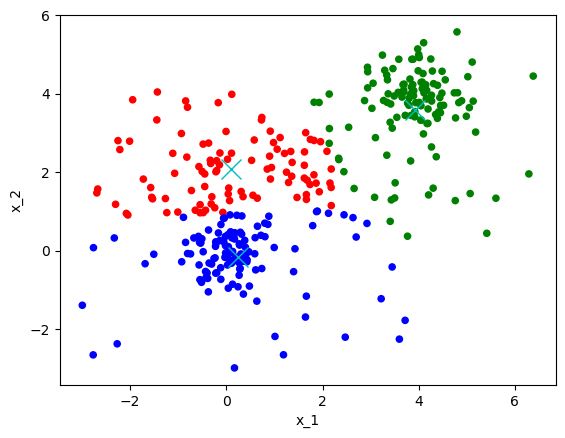

In [20]:
colors = {0:'blue', 1:'red', 2:'green'}
color_list = [colors[group] for group in df_labeled['label']]
df_labeled.plot.scatter('x_1','x_2', c=color_list)
plt.plot(centroids[:,0], centroids[0:,1], 'bo', marker='x', markersize = 15, color='c')